In [1]:
from multiprocessing import Pool
import warnings
import numpy as np
from numpy.typing import NDArray
import pandas as pd 
from pandas import DataFrame, Series
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import potions as pt

warnings.filterwarnings("ignore")

# Load data

In [2]:
data_path: str = "../input/Sleepers_Results.txt"
in_df: DataFrame = pd.read_csv(data_path, sep="\\s+", index_col="Date", parse_dates=True)

In [3]:
q_obs: Series = in_df["Qobs"]
in_df.head(1)

,Qsim,Qobs,Precipitation,Temperature,AET,PET,Snow,Snowcover,SM,Recharge,SUZ,SLZ,Q0,Q1,Q2,Qsim_rain,Qsim_snow
Date,,,,,,,,,,,,,,,,,
2016-10-01,0.49827,0.138,0.0,8.7,1.29,2.27,0.0,0.0,92.7,0.0,0.0,6.3,0.0,0.0,0.49827,0.496,0.002


# Create model and data structures

In [4]:
dates: Series = in_df.index # type: ignore
forc: pt.ForcingData = pt.ForcingData(
    precip=in_df.Precipitation,
    temp=in_df.Temperature,
    pet=in_df.PET
)

In [5]:
def create_model(arr: NDArray) -> pt.HydrologicModel:
    tt: float = arr[0]
    fmax: float = arr[1]
    fc: float = arr[2]
    lp: float = arr[3]
    beta: float = arr[4]
    k0: float = arr[5]
    thr: float = arr[6]
    k: float = arr[7]
    alpha: float = arr[8]

    snow_zone: pt.SnowZone = pt.SnowZone(tt, fmax)
    soil_zone: pt.SoilZone = pt.SoilZone(tt, fc, lp, beta, k0, thr)
    ground_zone: pt.GroundZone = pt.GroundZone(k, alpha, 0.0)

    hs: pt.Hillslope = pt.Hillslope([
        pt.Layer([snow_zone]),
        pt.Layer([soil_zone]),
        pt.Layer([ground_zone])
    ])

    model = pt.HydrologicModel(
        [hs],
        scales = [[1.0]]
    )

    return model

def run_model(params: NDArray) -> DataFrame:
    model: pt.HydrologicModel = create_model(params)
    init_state: NDArray = params[-3:]
    return pt.run_hydro_model(
        model=model,
        init_state=init_state,
        forc=[forc],
        dates=dates,
        dt=1.0
    )

def get_streamflow(df: DataFrame) -> Series:
    return df["q_lat_snow_0"] + df["q_lat_soil_1"] + df["q_lat_ground_2"]

def nse(q_sim: Series) -> float:
    num: float = ((q_sim - q_obs) ** 2).sum()
    den: float = ((q_obs - q_obs.mean()) ** 2).sum()

    return 1.0 - num / den

def obj_func(params: NDArray) -> float:
    res: DataFrame = run_model(params)
    q_sim: Series = get_streamflow(res)
    return -(nse(q_sim) - 1.0)

In [6]:
init_guess: NDArray = np.array([
    0.0,
    1.0,
    100.0,
    0.5,
    1.0,
    0.1,
    50.0,
    1e-3,
    1.0,
    0.0,
    25.0,
    50.0
])

res: DataFrame = run_model(init_guess)

In [7]:
bounds: list[tuple[float, float]] = [
    (-3, 3),
    (0.1, 5.0),
    (50, 1000),
    (0.1, 0.95),
    (0.5, 4.0),
    (1e-4, 0.5),
    (5, 150),
    (1e-5, 0.1),
    (0.25, 2.5),
    (0, 25),
    (0, 100),
    (0, 100),
]

# Run the minimization

In [8]:
opt_res = opt.minimize(
    obj_func, x0=init_guess, bounds=bounds
)

In [9]:
res = run_model(opt_res.x)

# Plot Results

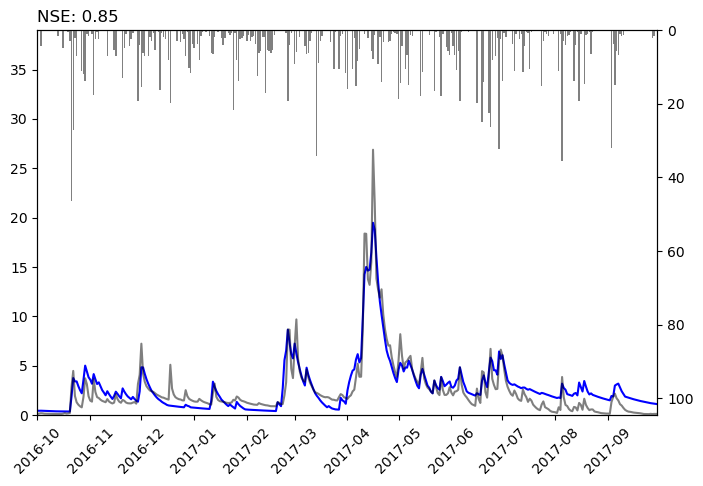

In [13]:
q_riv: Series = res["q_lat_snow_0"] + res["q_lat_soil_1"] + res["q_lat_ground_2"]
nse_val = nse(q_riv)
fig: Figure = plt.figure(figsize=(8,5))
ax: Axes = fig.gca()

ax.plot(dates, q_riv, label="Simulated", color="Blue")
ax.plot(dates, q_obs, label="Measured", color="Black", alpha=0.5)
ax.set_ylim(0, 2 * q_riv.max())
ax.set_xlim(dates.min(), dates.max())

ax2: Axes = ax.twinx()

ax2.bar(dates, in_df.Precipitation, color="gray")
ax2.set_ylim(0, 2.25 * in_df["Precipitation"].max())
ax2.invert_yaxis()
lbls = ax.get_xticklabels()
ax.set_xticklabels(lbls, rotation=45)
ax.set_title(f"NSE: {round(nse_val, 2)}", loc="left")
fig.show()

# Incorporating Markov-Chain Monte-Carlo sampling

In [9]:
from typing import Callable
import emcee

In [42]:
def log_prior(params: NDArray) -> float:
    for i, p_i in enumerate(params):
        # print(f"{bounds[i][0]} <= {p_i} <= {bounds[i][1]}")
        if not (bounds[i][0] <= p_i <= bounds[i][1]):
            return -np.inf

    return 0.0

def log_likelihood(params: NDArray, run_func: Callable[[NDArray], float]) -> float:
    obj_func = run_func(params)

    if np.isnan(obj_func) or np.isinf(obj_func):
        return -np.inf 
    
    if obj_func > 0.5:
        return -np.inf
    
    return -0.5 * (obj_func ** 2)

def log_probability(params: NDArray, run_func: Callable[[NDArray], float]) -> float:
    lp: float = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf 
    ll: float = log_likelihood(params, run_func)
    if not np.isfinite(ll):
        return -np.inf
    

    return lp + ll

In [44]:
ndim: int = len(init_guess)
num_walkers: int = 50
num_steps: int = 100
num_burn: int = 25
initial_pos = init_guess + 1e-1 * np.random.randn(num_walkers, ndim)
bounds_arr = np.array(bounds).T

In [45]:
for i in range(num_walkers):
    while not np.isfinite(log_prior(initial_pos[i, :])):
        # initial_pos[i, :] = init_guess + 1e-1 * np.random.randn(ndim)
        initial_pos[i, :] = bounds_arr[0] + (bounds_arr[1] - bounds_arr[0]) * np.random.uniform(0, 1.0, size=ndim)

In [46]:
with Pool(8) as pool:
    sampler = emcee.EnsembleSampler(num_walkers, ndim, log_probability, args=[obj_func], pool=pool)
    sampler.run_mcmc(initial_pos, num_steps, progress=True)

100%|██████████| 100/100 [12:22<00:00,  7.43s/it]  


In [26]:
arr = sampler.get_chain(discard=num_burn, flat=True)